# **Desafio Codenation**

# Descubra as melhores notas de matemática do ENEM 2016

Você deverá criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016. 

## Tópicos

Neste desafio você aprenderá:

- Python
- Pandas
- Sklearn
- Regression


## Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna **NU_NOTA_MT**) de quem participou do ENEM 2016. 

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO** e **NU_NOTA_MT**.

Neste notebook, iremos seguir os seguintes passos para fazer a predição ideal do dataset fornecido: 

01) Importação das Bibliotecas e Datasets

02) Descrição dos Dados

03) Encontrando Correlação entre as Features

04) Preenchimento dos Valores Faltantes

05) One Hot Encoder

06) Seleção das Features

07) Testando Modelo, Tunando Hyper Parâmetros e Realizando Submissão

## 01) Importação das Bibliotecas e Datasets

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 


import warnings
warnings.filterwarnings('ignore')

In [86]:
# Loading the dataframes
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 02) Descrição dos Dados

Vamos começar dando uma olhada geral nos dados que temos para ter uma idéia inicial sobre eles.

In [87]:
# Verifying the shape of the train and test data
train_data.shape, test_data.shape

((13730, 167), (4576, 47))

In [88]:
# Exclude the target column from the train data and matching the columns of the dataframes
target = 'NU_NOTA_MT'

y_train = train_data[target]

different = list(set(train_data.columns).difference(set(test_data.columns)))
different.remove('NU_NOTA_MT')

train_data.drop(different, axis=1, inplace=True)

train_data.shape, test_data.shape

((13730, 48), (4576, 47))

In [89]:
train_data[train_data['NU_NOTA_MT'] == 0]

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
111,6698841b20a8b8109a62ad87c39b775f9587acd0,43,RS,44,F,1,1,4,0,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,0.0,0.0,0.0,0.0,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,B,B,C,A,A,C,G,A
429,a398ec4cdbfc513d15b7b19893373c1a984e3158,35,SP,17,F,1,1,2,0,3,1.0,0,4.0,0,0,0,0,0,1,0,0,2,2,1,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,NaN,NaN,0.0,0.0,0,1.0,160.0,120.0,120.0,140.0,140.0,680.0,E,D,F,B,B,A,NaN,E
3442,f381da30391f67122dae82de6568b27404f75201,21,MA,22,F,3,1,1,2,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,366.6,375.0,394.2,0.0,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,C,C,B,A,A,A,NaN,A
3783,00ad8037ded099646c7cc989151ff84150679593,35,SP,19,M,1,1,1,1,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,438.1,506.2,375.9,0.0,1,1.0,80.0,80.0,80.0,80.0,40.0,360.0,H,H,B,B,A,A,NaN,A
4927,75615407a4c9eaaf38ed282d04450bfd7965847b,35,SP,17,F,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,493.8,497.0,0.0,0.0,0,1.0,120.0,120.0,120.0,100.0,80.0,540.0,H,D,B,A,A,A,NaN,A
7352,0c00b008a4d943970b88da0a139724652637d474,15,PA,18,F,3,1,1,1,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,471.2,565.2,0.0,0.0,0,1.0,120.0,120.0,120.0,100.0,100.0,560.0,B,D,A,A,A,A,NaN,A
7596,10771e954aa01c4b80a943b40bbbd1988d6fe64b,26,PE,18,F,3,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,422.4,509.0,546.4,0.0,0,1.0,120.0,120.0,100.0,120.0,40.0,500.0,D,E,C,A,A,C,E,A
8397,7828f55dcebce807b84c3d130ea6e6c14d43786f,25,PB,21,M,2,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,457.8,366.9,0.0,0.0,1,1.0,100.0,100.0,80.0,60.0,20.0,360.0,B,C,C,A,A,A,NaN,A
11645,b42cbdfccd92af892e3376ab876ab7ab8faee4c0,26,PE,16,M,2,1,3,0,1,NaN,1,NaN,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,434.9,381.7,0.0,0.0,1,1.0,80.0,60.0,80.0,60.0,60.0,340.0,C,E,A,A,A,A,NaN,A
13600,81fe4745b22b3a3f9653912c781e4e1f2c52e39e,25,PB,23,M,1,1,1,4,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0.0,326.2,0.0,0.0,0,1.0,120.0,80.0,80.0,80.0,40.0,400.0,D,E,B,C,B,A,NaN,A


### Análise das Colunas

Das 167 colunas inicias no dataset de treino, restaram apenas 47, uma vez que para realizar o teste só foram disponibilizadas 47 colunas, então precisamos igualar as colunas para que o teste seja condizente com o treino.

Estas 47 colunas são representadas das seguintes formas:
1. `NU_INSCRICAO` (Número de Inscrição): Alfanumérico de 12 digitos, todos são distintos.
2. `CO_UF_RESIDENCIA` (Código da Unidade da Federação de residência): Numérico com 2 dígitos, possuíndo 27 valores distintos.
3. `SG_UF_RESIDENCIA` (Sigla da Unidade da Federação de residência): Alfanumérico com 2 dígitos, possuíndo 27 valores distintos.
4. `NU_IDADE` (Idade): Numérico de 3 dígitos.
5. `TP_SEXO` (Sexo): Alfanumérica com um dígito (M ou F)
6. `TP_COR_RACA` (Cor/raça): Numérico com 1 dígito (0: Não declarado, 1: Branca, 2: Preta, 3: Parda, 4: Amarela, 5: Indígena, 6: Não dispõe da informação)
7. `TP_NACIONALIDADE` (Nacionalidade): Numérico com 1 dígito (0: Não informado, 1: Brasileiro, 2: Brasileiro Naturalizado, 3: Estrangeiro, 4: Brasileiro Nascido no Exterior)
8. `TP_ST_CONCLUSAO` (Situação de Conclusão do Ensino Médio): Numérico com 1 dígito (1: Já conclui Ensino Médio, 2: Estou cursando e concluirei em 2016, 3: Estou cursando e concluirei após 2016, 4: Não conclui e não estou cursando o Ensino Médio)
9. `TP_ANO_CONCLUIU` (Ano de conclusão do Ensino Médio): Numérico com 2 dígitos (0: Não Informado, 1: 2015, 2: 2014, 3: 2013, 4: 2012, 5: 2011, 6: 2010, 7: 2009, 8: 2008, 9: 2007, 10: Anterior a 2007)
10. `TP_ESCOLA` (Tipo de escola do Ensino Médio): Numérico com 1 dígito (1: Não Respondeu, 2: Pública, 3: Privada, 4: Exterior)
11. `TP_ENSINO` (Tipo de instituição de concluiu ou concluirá o Ensino Médio): Numérico com 1 dígito (1: Ensino Regular, 2: Educação Especial, 3: Educação de Jovens e Adultos) (Missing 68%)
12. `IN_TREINEIRO` (Candidato treineiro): Numérico de 1 dígito (1: Sim, 0: Não)
13. `TP_DEPENDENCIA_ADM_ESC` (Dependência Administrativa): Numérico com 1 dígito (1: Federal, 2: Estadual, 3: Municipal, 4: Privada) (Missing 68%)
14. `IN_BAIXA_VISAO` (Indicador de Baixa Visão): Numérico de 1 dígito (1: Sim, 0: Não)
15. `IN_CEGUEIRA` (Indicador de Cegueira): Numérico de 1 dígito (1: Sim, 0: Não) (100% dos valores são 0)
16. `IN_SURDEZ` (Indicador de Surdez): Numérico de 1 dígito (1: Sim, 0: Não)
17. `IN_DISLEXIA` (Indicador de Dislexia): Numérico de 1 dígito (1: Sim, 0: Não)
18. `IN_DISCALCULIA` (Indicador de Discalculia): Numérico de 1 dígito (1: Sim, 0: Não)
19. `IN_SABATISTA` (Indicador de Sabatista): Numérico de 1 dígito (1: Sim, 0: Não)
20. `IN_GESTANTE` (Indicador de Gestante): Numérico de 1 dígito (1: Sim, 0: Não)
21. `IN_IDOSO` (Indicador de Idoso): Numérico de 1 dígito (1: Sim, 0: Não)
22. `TP_PRSENCA_CN` (Presença na Prova de Ciências da Natureza) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
23. `TP_PRESENCA_CH` (Presença na Prova de Ciências Humanas) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
24. `TP_PRESENCA_LC` (Presença na Prova de Linguagens e Códigos) Numérico de 1 dígito (0: Faltou a Prova, 1: Presente na Prova, 2: Eliminado da Prova)
25. `CO_PROVA_CN` (Código da Prova de Ciências da Natureza) Numérico de 3 dígitos (291: Azul, 292: Amarela, 293: Branca, 294: Rosa, 307: Branca - Adaptada, 331: Azul (Reaplicação), 332: Amarela (Reaplicação), 333: Branca (Reaplicação), 334: Rosa (Reaplicação), 351: Azul (Reaplicação), 352: Amarela (Reaplicação), 353: Branca (Reaplicação), 354: Rosa (Reaplicação), 355: Branca - Adaptada (Reaplicação)) 
26. `CO_PROVA_CH` (Código da Prova de Ciências Humanas) Numérico de 3 dígitos (291: Azul, 292: Amarela, 293: Branca, 294: Rosa, 307: Branca - Adaptada, 331: Azul (Reaplicação), 332: Amarela (Reaplicação), 333: Branca (Reaplicação), 334: Rosa (Reaplicação), 351: Azul (Reaplicação), 352: Amarela (Reaplicação), 353: Branca (Reaplicação), 354: Rosa (Reaplicação), 355: Branca - Adaptada (Reaplicação)) 
27. `CO_PROVA_LC` (Código da Prova de Linguagens e Códigos) Numérico de 3 dígitos (291: Azul, 292: Amarela, 293: Branca, 294: Rosa, 307: Branca - Adaptada, 331: Azul (Reaplicação), 332: Amarela (Reaplicação), 333: Branca (Reaplicação), 334: Rosa (Reaplicação), 351: Azul (Reaplicação), 352: Amarela (Reaplicação), 353: Branca (Reaplicação), 354: Rosa (Reaplicação), 355: Branca - Adaptada (Reaplicação)) 
28. `CO_PROVA_MT` (Código da Prova de Matemática) Numérico de 3 dígitos (291: Azul, 292: Amarela, 293: Branca, 294: Rosa, 307: Branca - Adaptada, 331: Azul (Reaplicação), 332: Amarela (Reaplicação), 333: Branca (Reaplicação), 334: Rosa (Reaplicação), 351: Azul (Reaplicação), 352: Amarela (Reaplicação), 353: Branca (Reaplicação), 354: Rosa (Reaplicação), 355: Branca - Adaptada (Reaplicação))
29. `NU_NOTA_CN` (Nota na Prova de Ciências da Natureza): Numérico de 9 dígitos
30. `NU_NOTA_CH` (Nota na Prova de Ciências Humanas): Numérico de 9 dígitos
31. `NU_NOTA_LC` (Nota na Prova de Linguagens e Códigos): Numérico de 9 dígitos
32. `NU_NOTA_MT` **(Nota na Prova de Matemática): Numérico de 9 dígitos**
33. `TP_LINGUA`(Lingua Estrangeira): Numérico de 1 dígito (0: Inglês, 1: Espanhol)
34. `TP_STATUS_REDACAO` (Situação da Redação): Numérico de 1 dígito (1: Sem Problemas, 2: Anulada, 3: Copia Texto Motivador, 4: Em Branco, 5: Fere Direitos Humanos, 6: Fuga ao Tema, 7: Não Atendimento ao Tipo, 8: Texto Insuficiente, 9: Parte Desconectada)
35. `NU_NOTA_COMP1` (Nota da Competência 1): Numérico
36. `NU_NOTA_COMP2` (Nota da Competência 2): Numérico
37. `NU_NOTA_COMP3` (Nota da Competência 3): Numérico
38. `NU_NOTA_COMP4` (Nota da Competência 4): Numérico
39. `NU_NOTA_COMP5` (Nota da Competência 5): Numérico
40. `NU_NOTA_REDACAO` (Nota da Prova de Redação): Numérico
41. `Q001` (Até que série seu pai, ou o homem responsável por você, estudou?): Alfanumérico com 1 dígito (A: Nunca Estudou, B: Não completou a 4ª série/5º ano do Ensino Fundamental, C: Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental, D: Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio, E: Completou o Ensino Médio, mas não completou a Faculdade, F: Completou a Faculdade, mas não completou a Pós-graduação, Completou a Pós-graduação, H: Não sei)
42. `Q002` (Até que série sua mãe, ou a mulher responsável por você, estudou?): Alfanumérico com 1 dígito (A: Nunca Estudou, B: Não completou a 4ª série/5º ano do Ensino Fundamental, C: Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental, D: Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio, E: Completou o Ensino Médio, mas não completou a Faculdade, F: Completou a Faculdade, mas não completou a Pós-graduação, Completou a Pós-graduação, H: Não sei)
43. `Q006` (Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)): Alfanumérico com 1 dígito (A: Nenhuma renda, B: Até 880,00, C: De 880,01 até 1.320,00, D: De 1.320,01 até 1.760,00, E: De 1.760,01 até 2.200,00, F: De 2.200,01 até 2.640,00, G: De 2.640,01 até 3.520,00, H: De 3.520,01 até 4.400,00, I: De 4.400,01 até 5.280,00, J: De 5.280,01 até 6.160,00, K: De 6.160,01 até 7.040,00, L: De 7.040,01 até 7.920,00, M: De 7.920,01 até 8.800,00, N: De 8.800,01 até 10.560,00, O: De 10.560,01 até 13.200,00, P: De 13.200,01 até 17.600,00, Q: Mais de 17.600,00)
44. `Q024` (Na sua residência tem computador?): Alfanumérico com 1 dígito (A: Não, B: Sim, um, C: Sim, dois, D: Sim, três, E: Sim, quatro ou mais)
45. `Q025` (Na sua residência tem acesso à Internet?): Alfanumérico com 1 dígito (A: Não, B: Sim)
46. `Q026` (Você exerce ou já exerceu atividade remunerada?): Alfanumérico com 1 dígito (A: Não, nunca trabalhei, B: Sim, já trabalhei, mas não estou trabalhando, C: Sim, estou trabalhando)
47. `Q027` (Com que idade você começou a exercer uma atividade remunerada?): Alfanumérico com 1 dígito (A: Menos de 14 anos, B: 14 anos, C: 15 anos, D: 16 anos, E: 17 anos, F: 18 anos, G: 19 anos, H: 20 anos, I: 21 anos, J: 22 anos, K: 23 anos, L: 24 anos, M: 25 anos ou mais) (Missing 53%)
48. `Q047` (Em que tipo de escola você frequentou o Ensino Médio?): Alfanumérico com 1 dígito (A: Somente em escola pública, B: Parte em escola pública e parte em escola privada sem bolsa de estudo integral, C: Parte em escola pública e parte em escola privada com bolsa de estudo integral, D: Somente em escola privada sem bolsa de estudo integral, E: Somente em escola privada com bolsa de estudo integral)

**Obesrvação**: Claramente as colunas `NU_INSCRICAO`, `SG_UF_RESIDENCIA`, `CO_PROVA_CN`, `CO_PROVA_CH`, `CO_PROVA_LC` e `CO_PROVA_MT` não terão relação com a nossa predição.

In [90]:
# Looking the type of the columns in the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 48 columns):
NU_INSCRICAO              13730 non-null object
CO_UF_RESIDENCIA          13730 non-null int64
SG_UF_RESIDENCIA          13730 non-null object
NU_IDADE                  13730 non-null int64
TP_SEXO                   13730 non-null object
TP_COR_RACA               13730 non-null int64
TP_NACIONALIDADE          13730 non-null int64
TP_ST_CONCLUSAO           13730 non-null int64
TP_ANO_CONCLUIU           13730 non-null int64
TP_ESCOLA                 13730 non-null int64
TP_ENSINO                 4282 non-null float64
IN_TREINEIRO              13730 non-null int64
TP_DEPENDENCIA_ADM_ESC    4282 non-null float64
IN_BAIXA_VISAO            13730 non-null int64
IN_CEGUEIRA               13730 non-null int64
IN_SURDEZ                 13730 non-null int64
IN_DISLEXIA               13730 non-null int64
IN_DISCALCULIA            13730 non-null int64
IN_SABATISTA              13730 non-null

In [91]:
# The description of the train dataset
train_data.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,4282.000000,13730.000000,4282.000000,13730.000000,13730.0,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000
mean,30.736708,21.593809,2.185652,1.048871,1.782666,2.146176,1.353532,1.178888,0.129862,2.259692,0.001238,0.0,0.000364,0.000073,0.000073,0.009687,0.000947,0.000146,0.754479,0.754479,0.738747,473.495155,529.661087,516.472841,482.497928,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258
std,9.862405,7.043654,1.007285,0.258895,0.880734,3.217328,0.558472,0.565490,0.336163,0.698586,0.035167,0.0,0.019080,0.008534,0.008534,0.097947,0.030757,0.012069,0.431932,0.431932,0.440162,71.093674,73.726344,68.688190,99.826323,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758
min,11.000000,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,419.900000,480.400000,468.100000,408.900000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000
50%,31.000000,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,459.800000,532.000000,520.900000,461.200000,1.000000,1.000000,120.000000,120.000000,120.000000,120.000000,80.000000,540.000000
75%,35.000000,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,514.500000,581.200000,564.900000,537.600000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000
max,53.000000,67.000000,5.000000,4.000000,4.000000,10.000000,4.000000,3.000000,1.000000,4.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,806.400000,807.000000,763.600000,952.000000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000


## 03) Encontrando Correlação entre as Features


In [92]:
# Showing the numerical varibales with the highest correlation with 'NU_NOTA_MT', sorted from highest to lowest
correlation = train_data.select_dtypes(include=[np.number]).corr()
print(correlation['NU_NOTA_MT'].sort_values(ascending=False))

NU_NOTA_MT                1.000000
NU_NOTA_CN                0.584941
NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_REDACAO           0.379376
TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP5             0.343337
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP1             0.299402
CO_UF_RESIDENCIA          0.107493
TP_ESCOLA                 0.069304
TP_ANO_CONCLUIU           0.029039
IN_DISCALCULIA            0.009813
TP_PRESENCA_CH            0.003552
TP_PRESENCA_CN            0.003552
IN_DISLEXIA               0.001453
IN_BAIXA_VISAO            0.000685
IN_GESTANTE              -0.000945
IN_IDOSO                 -0.011336
IN_SURDEZ                -0.015249
IN_SABATISTA             -0.016459
IN_TREINEIRO             -0.022287
TP_NACIONALIDADE         -0.034965
TP_STATUS_REDACAO        -0.059376
NU_IDADE                 -0.061485
TP_ENSINO                -0.086353
TP_ST_CONCLUSAO     

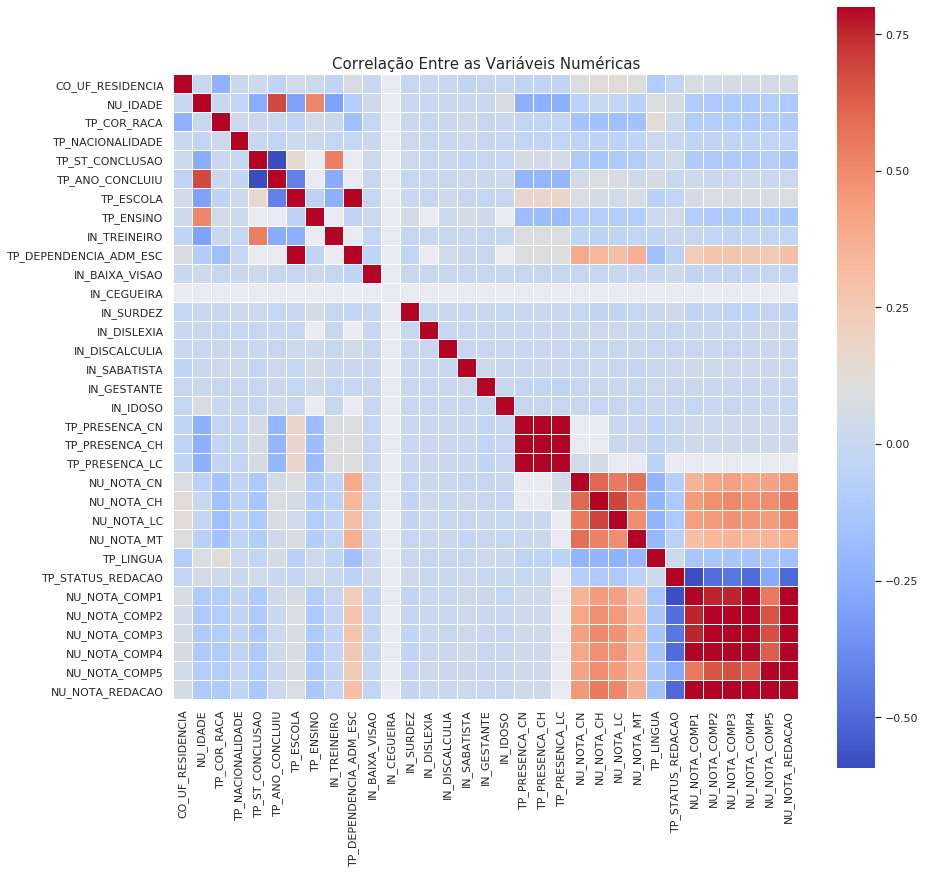

In [93]:
# Heatmap of correlation of numeric features
fig, ax = plt.subplots(figsize = (14,14))

plt.title('Correlação Entre as Variáveis Numéricas', size=15)

sns.heatmap(correlation, square=True, vmax=0.8, cmap='coolwarm', linewidths=0.01);

Podemos observar algumas correlações entre as variáveis numéricas:

* A variável `TP_ANO_CONCLUIU` tem relação com a variável `NU_IDADE`
* A variável `TP_ENSINO` tem relação com a variável `NU_IDADE`
* A variável `TP_TREINEIRO` tem relação com a variável `TP_ST_CONCLUSAO`
* A variável `TP_DEPENDENCIA_ADM_ESC` tem relação com a variável `TP_ESCOLA`
* As variáveis `TP_PRESENCA_CN`, `TP_PRESENCA_CH` e `TP_PRESENCA_LC` possuem correlação
* As variáveis `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_LC` e `NU_NOTA_MT` possuem correlação
* As variáveis `NU_NOTA_COMP1`, `NU_NOTA_COMP2`, `NU_NOTA_COMP3`, `NU_NOTA_COMP4`, `NU_NOTA_COMP5` e `NU_NOTA_REDACAO` possuem correlação
* Para a variável alvo (`NU_NOTA_MT`), existem correlação com `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_LC`, `NU_NOTA_REDACAO` e `TP_DEPENDENCIA_ADM_ESC`

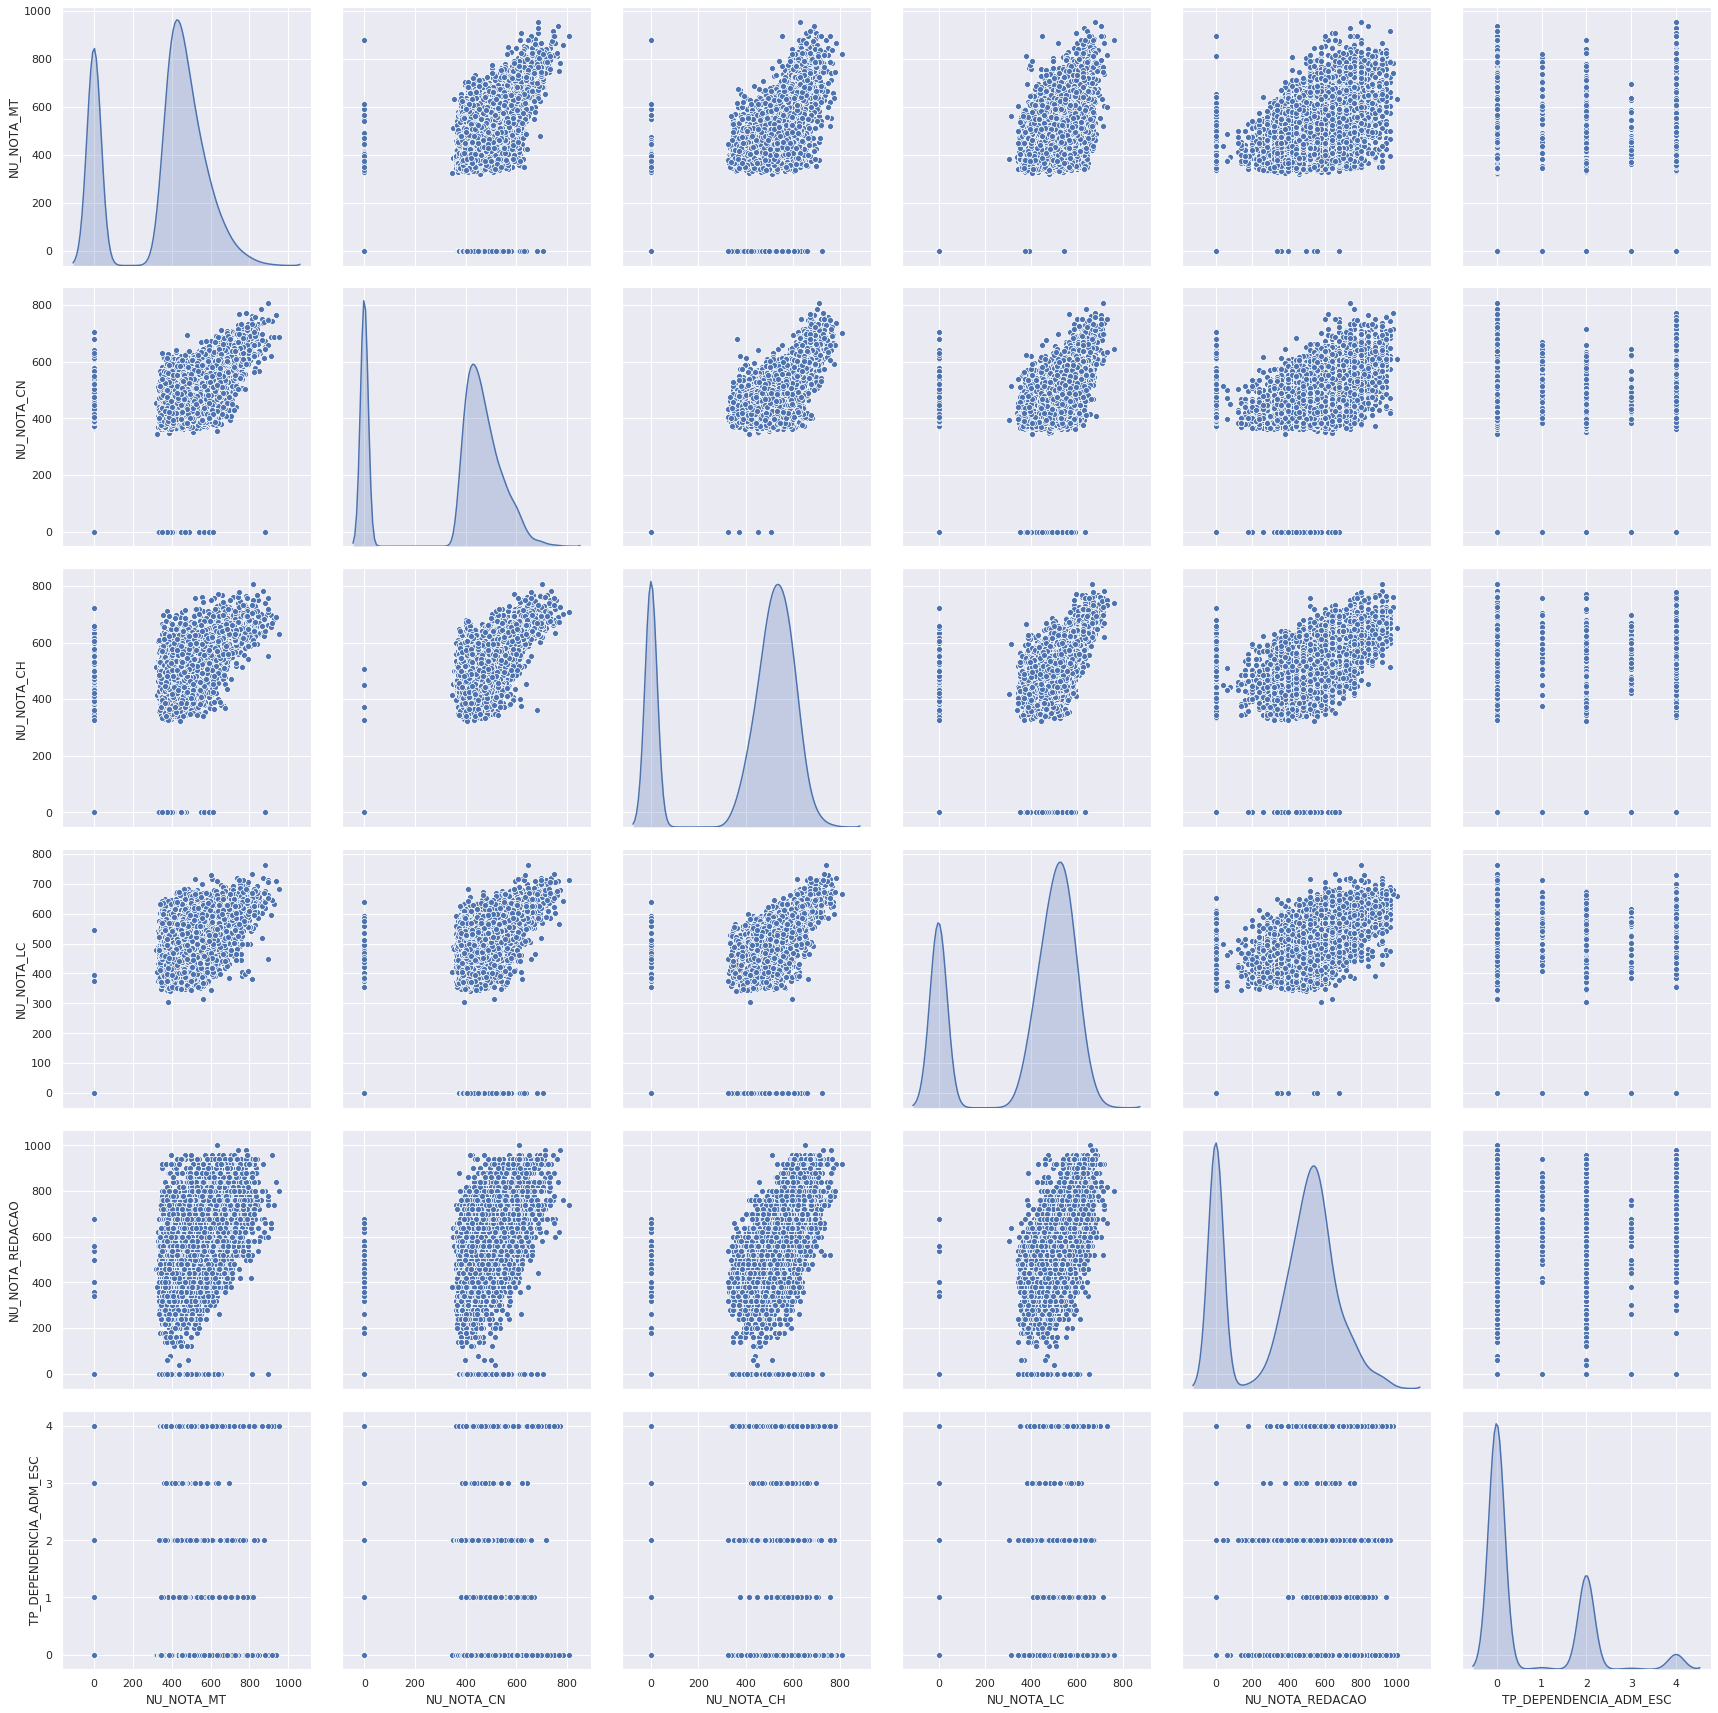

In [94]:
# Pair plot
cols = ['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_DEPENDENCIA_ADM_ESC']

temp_train_data = train_data.fillna(0)

sns.set()
sns.pairplot(temp_train_data[cols], height=4, kind='scatter', diag_kind='kde')
plt.show()

A partir destes gráficos, fica evidente que praticamente apenas as notas 0 são os únicos outliers, não as removeremos por enquanto.

## 04) Preenchimento dos Valores Faltantes

Vejamos o valores ausentes em nossos dados. Nós estaremos usando a biblioteca msno. Esta biblioteca fornece um pequeno conjunto de ferramentas de visualizações e utilitários de dados ausentes, flexíveis e fáceis de usar, que permitem obter um resumo visual rápido da integridade (ou falta dela) do conjunto de dados.

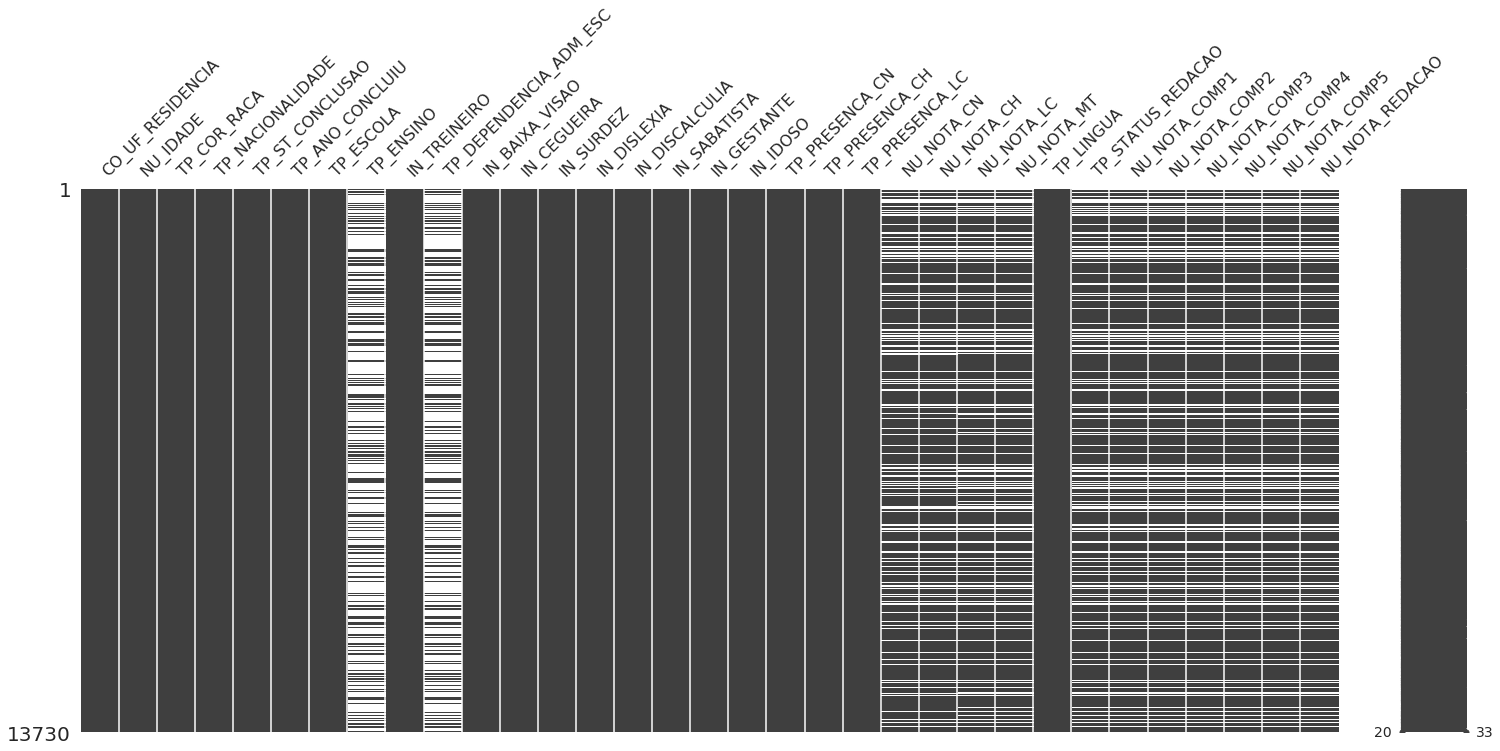

In [95]:
# Visualising missing values of numeric features
msno.matrix(train_data.select_dtypes(include=[np.number]));

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_CN` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_CN` (NU_NOTA_CN com 3389 NaNs e TP_PRESENCA_CN com 3380 valores 0 (ausente) e 9 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_CN` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_CH` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_CH` (NU_NOTA_CH com 3389 NaNs e TP_PRESENCA_CH com 3380 valores 0 (ausente) e 9 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_CH` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_LC` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (NU_NOTA_LC com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Com isso podemos preencher os NaNs da coluna `NU_NOTA_LC` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `NU_NOTA_MT` é exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (NU_NOTA_LC com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Ambas as provas ocorrem no mesmo dia, não tem como ser ausente em uma e presente na outra. Com isso podemos preencher os NaNs da coluna `NU_NOTA_MT` com zeros.

* Nota-se que os valores preenchidos com NaN na coluna `TP_STATUS_REDACAO`, `NU_NOTA_COMP_1`, `NU_NOTA_COMP_2`, `NU_NOTA_COMP_3`, `NU_NOTA_COMP_4`, `NU_NOTA_COMP_5` e `NU_NOTA_REDACAO` são exatamente o número de pessoas ausentes ou eliminadas da prova, conforme coluna `TP_PRSENCA_LC` (TP_STATUS_REDACAO, NU_NOTA_COMP_1, NU_NOTA_COMP_2, NU_NOTA_COMP_3, NU_NOTA_COMP_4, NU_NOTA_COMP_5 e NU_NOTA_REDACAO com 3597 NaNs e TP_PRESENCA_CN com 3592 valores 0 (ausente) e 5 valores 2 (eliminado)). Com isso podemos preencher os NaNs das colunas `TP_STATUS_REDACAO`, `NU_NOTA_COMP_1`, `NU_NOTA_COMP_2`, `NU_NOTA_COMP_3`, `NU_NOTA_COMP_4`, `NU_NOTA_COMP_5` e `NU_NOTA_REDACAO` com zeros.

* As colunas `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` possuem um alto número de valores faltantes (68%). Poderiamos excluí-las, entretanto, `TP_DEPENDENCIA_ADM_ESC` possui alta correlação com a nota `NU_NOTA_MT`. Sendo assim, iremos caracterizar os  NaNs como zeros, não tentando adivinhar de qual tipo de escola o candidato estuda, podendo afetar negativamente a predição.

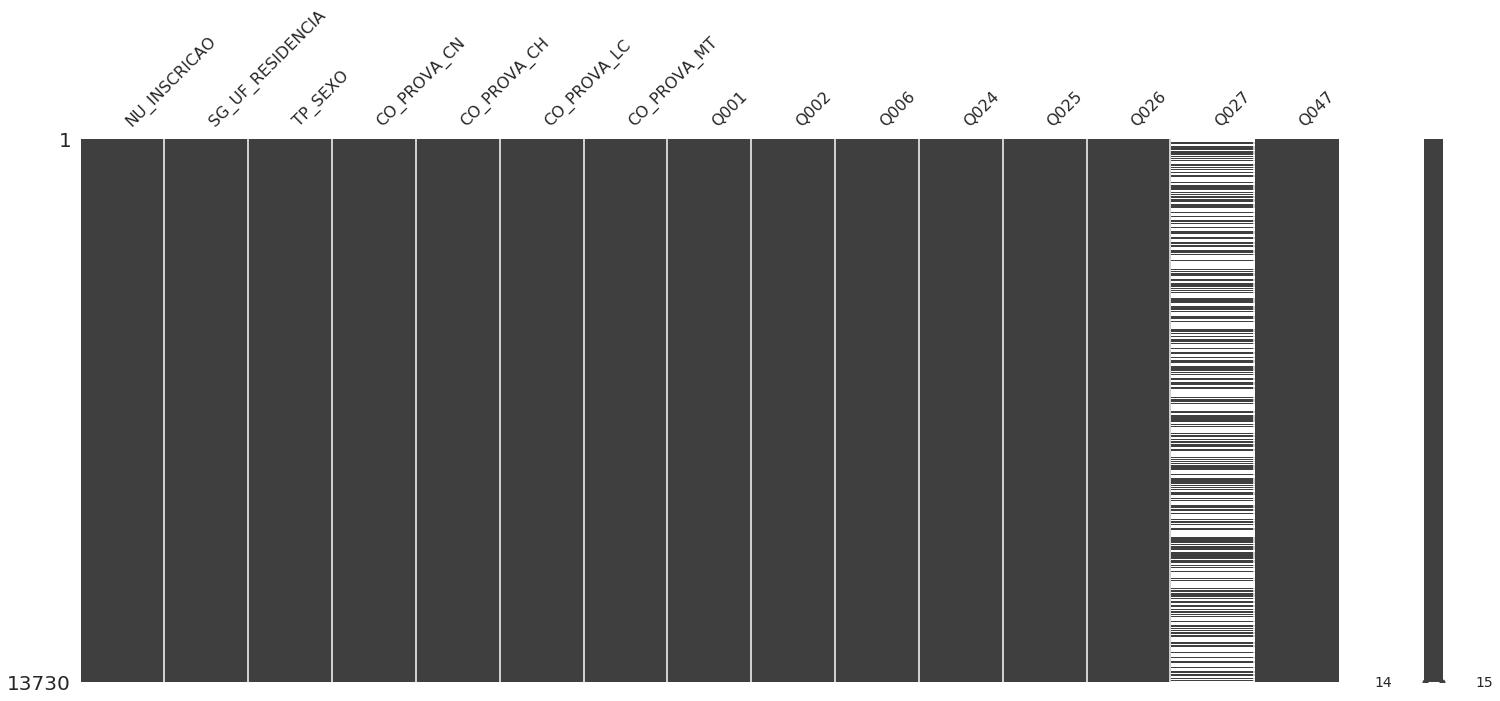

In [96]:
# Visualising missing values of object features
msno.matrix(train_data.select_dtypes(include=[np.object]));

* Nota-se que os valores preenchidos com NaN na coluna `Q027` (53.7%) provavelmente são relacionados as pessoas que nunca exerceram uma atividade remunerada. Sendo assim criaremos uma nova alternativa para resposta (N: Nunca exerci uma atividade remunerada) e substituiremos os NaNs por esta alternativa (pela letra 'N').

Primeiramente, vamos começar substituindo os valores ausentes no treinamento e no conjunto de testes. Então, combinaremos os dois conjuntos de dados em um único.

In [97]:
# First replace the NaNs in NU_NOTA_MT column with 0
train_data['NU_NOTA_MT'].fillna(0, inplace=True)

# Concatenate the training and test datasets into a single dataframe
data_full = pd.concat([train_data, test_data], ignore_index=True)
data_full.shape

(18306, 48)

In [98]:
# Numeric features: replace with 0
temp_cols = ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 
             'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_STATUS_REDACAO', 
             'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']


for col in temp_cols:
    data_full[col].fillna(0, inplace=True)

# Check if missing values are imputed successfully
sum_missing_values = data_full.select_dtypes(include=[np.number]).isnull().sum()
sum_missing_values[sum_missing_values > 0].sort_values(ascending=False)

NU_NOTA_MT    4576
dtype: int64

In [99]:
# Object feature Q027: replace with N
data_full['Q027'].fillna('N', inplace=True)

# Check if missing values are imputed successfully
sum_missing_values = data_full.select_dtypes(include=[np.object]).isnull().sum()
sum_missing_values[sum_missing_values > 0].sort_values(ascending=False)

Series([], dtype: int64)

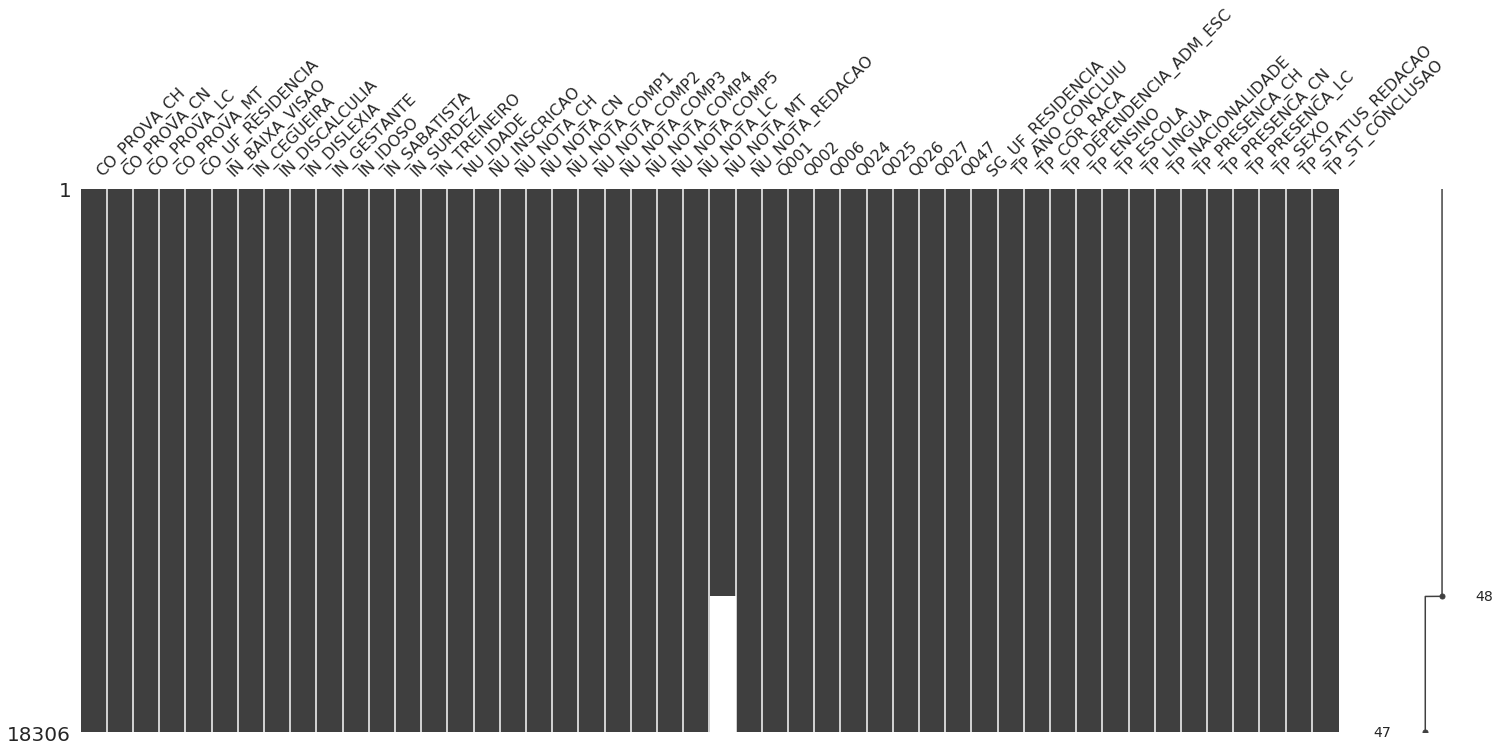

In [100]:
# Visualising missing values of all (Expected missing values just in a test set part with NU_NOTA_MT)
msno.matrix(data_full.select_dtypes(include=[np.object, np.number]));

## 05) One Hot Encoder

Por enquanto, tempos estas variáveis vislumbradas para se utilizar no modelo:

* Numéricas prontas: `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_LC`, `NU_NOTA_REDACAO`
* Numéricas que precisam de One Hot Encoder: `TP_DEPENDENCIA_ADM_ESC`, `CO_UF_RESIDENCIA`, `TP_COR_RACA`, `TP_LINGUA`               
* Objetivas que precisam virar numéricas e depois precisam de One Hot Encoder: `TP_SEXO`, `Q001`, `Q002`, `Q006`, `Q024`, `Q025`, `Q026`, `Q027`, `Q047`

In [101]:
data_full.head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,CO_UF_RESIDENCIA,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,IN_IDOSO,IN_SABATISTA,IN_SURDEZ,IN_TREINEIRO,NU_IDADE,NU_INSCRICAO,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,SG_UF_RESIDENCIA,TP_ANO_CONCLUIU,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,TP_ENSINO,TP_ESCOLA,TP_LINGUA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_SEXO,TP_STATUS_REDACAO,TP_ST_CONCLUSAO
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,43,0,0,0,0,0,0,0,0,0,24,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,495.4,436.3,120.0,120.0,120.0,80.0,80.0,581.2,399.4,520.0,D,D,C,A,A,C,H,A,RS,4,1,0.0,0.0,1,1,1,1,1,1,M,1.0,1
1,909237ab0d84688e10c0470e2997348aff585273,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,23,0,0,0,0,0,0,0,0,0,17,2c3acac4b33ec2b195d77e7c04a2d75727fad723,544.1,474.5,140.0,120.0,120.0,120.0,80.0,599.0,459.8,580.0,A,A,B,A,A,A,N,A,CE,0,3,2.0,1.0,2,1,1,1,1,1,F,1.0,2
2,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,23,0,0,0,0,0,0,0,0,0,21,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,D,C,A,A,A,N,A,CE,0,3,0.0,0.0,1,1,1,0,0,0,F,0.0,3
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,33,0,0,0,0,0,0,0,0,0,25,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,E,E,C,B,C,F,D,RJ,9,0,0.0,0.0,1,0,1,0,0,0,F,0.0,1
4,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,13,0,0,0,0,0,0,0,0,0,28,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E,D,C,A,A,B,F,A,AM,4,2,0.0,0.0,1,1,1,0,0,0,M,0.0,1


In [102]:
# Create a One Hot Encoder function
def one_hot_encoder(dataframe, feature):
    dummies = pd.get_dummies(dataframe[feature], prefix=feature)
    result = pd.concat([dataframe, dummies], axis=1)
    result = result.drop([feature], axis=1)
    
    return(result) 

# Doing One Hot Encode in 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_RESIDENCIA', 'TP_COR_RACA' and 'TP_LINGUA' columns
data = data_full.copy()

features_to_encode = ['TP_DEPENDENCIA_ADM_ESC', 'CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_LINGUA']
                      
for feature in features_to_encode:
    data = one_hot_encoder(data, feature)

data.head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,IN_IDOSO,IN_SABATISTA,IN_SURDEZ,IN_TREINEIRO,NU_IDADE,NU_INSCRICAO,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,SG_UF_RESIDENCIA,TP_ANO_CONCLUIU,TP_ENSINO,TP_ESCOLA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_SEXO,TP_STATUS_REDACAO,TP_ST_CONCLUSAO,TP_DEPENDENCIA_ADM_ESC_0.0,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,CO_UF_RESIDENCIA_24,CO_UF_RESIDENCIA_25,CO_UF_RESIDENCIA_26,CO_UF_RESIDENCIA_27,CO_UF_RESIDENCIA_28,CO_UF_RESIDENCIA_29,CO_UF_RESIDENCIA_31,CO_UF_RESIDENCIA_32,CO_UF_RESIDENCIA_33,CO_UF_RESIDENCIA_35,CO_UF_RESIDENCIA_41,CO_UF_RESIDENCIA_42,CO_UF_RESIDENCIA_43,CO_UF_RESIDENCIA_50,CO_UF_RESIDENCIA_51,CO_UF_RESIDENCIA_52,CO_UF_RESIDENCIA_53,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_LINGUA_0,TP_LINGUA_1
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,24,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,495.4,436.3,120.0,120.0,120.0,80.0,80.0,581.2,399.4,520.0,D,D,C,A,A,C,H,A,RS,4,0.0,1,1,1,1,1,M,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,909237ab0d84688e10c0470e2997348aff585273,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,17,2c3acac4b33ec2b195d77e7c04a2d75727fad723,544.1,474.5,140.0,120.0,120.0,120.0,80.0,599.0,459.8,580.0,A,A,B,A,A,A,N,A,CE,0,1.0,2,1,1,1,1,F,1.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,21,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,D,C,A,A,A,N,A,CE,0,0.0,1,1,0,0,0,F,0.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,25,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H,E,E,C,B,C,F,D,RJ,9,0.0,1,1,0,0,0,F,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,28,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E,D,C,A,A,B,F,A,AM,4,0.0,1,1,0,0,0,M,0.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [103]:
data.shape

(18306, 84)

In [104]:
# Replace the object values from numberic values

data = data.copy()

data['TP_SEXO'] = data_full['TP_SEXO'].map({'M':1, 'F':2})
data['Q001'] = data_full['Q001'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8})
data['Q002'] = data_full['Q002'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8})
data['Q006'] = data_full['Q006'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10, 'K':11, 'L':12, 'M':13, 'N':14, 'O':15, 'P':16, 'Q':17})
data['Q024'] = data_full['Q024'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})
data['Q025'] = data_full['Q025'].map({'A':1, 'B':2})
data['Q026'] = data_full['Q026'].map({'A':1, 'B':2, 'C':3})
data['Q027'] = data_full['Q027'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10, 'K':11, 'L':12, 'M':13, 'N':14})
data['Q047'] = data_full['Q047'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5})

data.head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,IN_IDOSO,IN_SABATISTA,IN_SURDEZ,IN_TREINEIRO,NU_IDADE,NU_INSCRICAO,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,SG_UF_RESIDENCIA,TP_ANO_CONCLUIU,TP_ENSINO,TP_ESCOLA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_SEXO,TP_STATUS_REDACAO,TP_ST_CONCLUSAO,TP_DEPENDENCIA_ADM_ESC_0.0,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,CO_UF_RESIDENCIA_24,CO_UF_RESIDENCIA_25,CO_UF_RESIDENCIA_26,CO_UF_RESIDENCIA_27,CO_UF_RESIDENCIA_28,CO_UF_RESIDENCIA_29,CO_UF_RESIDENCIA_31,CO_UF_RESIDENCIA_32,CO_UF_RESIDENCIA_33,CO_UF_RESIDENCIA_35,CO_UF_RESIDENCIA_41,CO_UF_RESIDENCIA_42,CO_UF_RESIDENCIA_43,CO_UF_RESIDENCIA_50,CO_UF_RESIDENCIA_51,CO_UF_RESIDENCIA_52,CO_UF_RESIDENCIA_53,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_LINGUA_0,TP_LINGUA_1
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,24,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,495.4,436.3,120.0,120.0,120.0,80.0,80.0,581.2,399.4,520.0,4,4,3,1,1,3,8,1,RS,4,0.0,1,1,1,1,1,1,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,909237ab0d84688e10c0470e2997348aff585273,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,17,2c3acac4b33ec2b195d77e7c04a2d75727fad723,544.1,474.5,140.0,120.0,120.0,120.0,80.0,599.0,459.8,580.0,1,1,2,1,1,1,14,1,CE,0,1.0,2,1,1,1,1,2,1.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,21,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,3,1,1,1,14,1,CE,0,0.0,1,1,0,0,0,2,0.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,25,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,5,5,3,2,3,6,4,RJ,9,0.0,1,1,0,0,0,2,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,28,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,3,1,1,2,6,1,AM,4,0.0,1,1,0,0,0,1,0.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [105]:
# Doing One Hot Encode in 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027' and 'Q047'

features_to_encode = ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047']
                      
for feature in features_to_encode:
    data = one_hot_encoder(data, feature)

data.head()

,CO_PROVA_CH,CO_PROVA_CN,CO_PROVA_LC,CO_PROVA_MT,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,IN_IDOSO,IN_SABATISTA,IN_SURDEZ,IN_TREINEIRO,NU_IDADE,NU_INSCRICAO,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,SG_UF_RESIDENCIA,TP_ANO_CONCLUIU,TP_ENSINO,TP_ESCOLA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_STATUS_REDACAO,TP_ST_CONCLUSAO,TP_DEPENDENCIA_ADM_ESC_0.0,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,CO_UF_RESIDENCIA_24,CO_UF_RESIDENCIA_25,CO_UF_RESIDENCIA_26,CO_UF_RESIDENCIA_27,CO_UF_RESIDENCIA_28,CO_UF_RESIDENCIA_29,CO_UF_RESIDENCIA_31,CO_UF_RESIDENCIA_32,CO_UF_RESIDENCIA_33,CO_UF_RESIDENCIA_35,CO_UF_RESIDENCIA_41,CO_UF_RESIDENCIA_42,CO_UF_RESIDENCIA_43,CO_UF_RESIDENCIA_50,CO_UF_RESIDENCIA_51,CO_UF_RESIDENCIA_52,CO_UF_RESIDENCIA_53,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_LINGUA_0,TP_LINGUA_1,TP_SEXO_1,TP_SEXO_2,Q001_1,Q001_2,Q001_3,Q001_4,Q001_5,Q001_6,Q001_7,Q001_8,Q002_1,Q002_2,Q002_3,Q002_4,Q002_5,Q002_6,Q002_7,Q002_8,Q006_1,Q006_2,Q006_3,Q006_4,Q006_5,Q006_6,Q006_7,Q006_8,Q006_9,Q006_10,Q006_11,Q006_12,Q006_13,Q006_14,Q006_15,Q006_16,Q006_17,Q024_1,Q024_2,Q024_3,Q024_4,Q024_5,Q025_1,Q025_2,Q026_1,Q026_2,Q026_3,Q027_1,Q027_2,Q027_3,Q027_4,Q027_5,Q027_6,Q027_7,Q027_8,Q027_9,Q027_10,Q027_11,Q027_12,Q027_13,Q027_14,Q047_1,Q047_2,Q047_3,Q047_4,Q047_5
0,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,24,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,495.4,436.3,120.0,120.0,120.0,80.0,80.0,581.2,399.4,520.0,RS,4,0.0,1,1,1,1,1,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,909237ab0d84688e10c0470e2997348aff585273,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,0,0,0,0,0,0,0,0,0,17,2c3acac4b33ec2b195d77e7c04a2d75727fad723,544.1,474.5,140.0,120.0,120.0,120.0,80.0,599.0,459.8,580.0,CE,0,1.0,2,1,1,1,1,1.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,21,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CE,0,0.0,1,1,0,0,0,0.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,25,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RJ,9,0.0,1,1,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,0,0,0,0,0,0,0,0,28,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,0.0,0.0,0.0,0.0,0.0,

## 07) Seleção das Features

Precisamos agora selecionar quais variáveis utilizaremos no modelo e quais removeremos do dataframe. Inicialmente, vamos remover todas as features do tipo objeto e utilizar todas as demais. São elas: `NU_INSCRICAO`, `SG_UF_RESIDENCIA`, `CO_PROVA_CN` `CO_PROVA_CH`, `CO_PROVA_LC` e `CO_PROVA_MT`.

In [106]:
data.shape

(18306, 139)

In [107]:
data.drop(columns=['NU_INSCRICAO', 'SG_UF_RESIDENCIA', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], inplace=True)
data.shape

(18306, 133)

In [108]:
data.head()

,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_DISCALCULIA,IN_DISLEXIA,IN_GESTANTE,IN_IDOSO,IN_SABATISTA,IN_SURDEZ,IN_TREINEIRO,NU_IDADE,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_ANO_CONCLUIU,TP_ENSINO,TP_ESCOLA,TP_NACIONALIDADE,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_STATUS_REDACAO,TP_ST_CONCLUSAO,TP_DEPENDENCIA_ADM_ESC_0.0,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,CO_UF_RESIDENCIA_24,CO_UF_RESIDENCIA_25,CO_UF_RESIDENCIA_26,CO_UF_RESIDENCIA_27,CO_UF_RESIDENCIA_28,CO_UF_RESIDENCIA_29,CO_UF_RESIDENCIA_31,CO_UF_RESIDENCIA_32,CO_UF_RESIDENCIA_33,CO_UF_RESIDENCIA_35,CO_UF_RESIDENCIA_41,CO_UF_RESIDENCIA_42,CO_UF_RESIDENCIA_43,CO_UF_RESIDENCIA_50,CO_UF_RESIDENCIA_51,CO_UF_RESIDENCIA_52,CO_UF_RESIDENCIA_53,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_LINGUA_0,TP_LINGUA_1,TP_SEXO_1,TP_SEXO_2,Q001_1,Q001_2,Q001_3,Q001_4,Q001_5,Q001_6,Q001_7,Q001_8,Q002_1,Q002_2,Q002_3,Q002_4,Q002_5,Q002_6,Q002_7,Q002_8,Q006_1,Q006_2,Q006_3,Q006_4,Q006_5,Q006_6,Q006_7,Q006_8,Q006_9,Q006_10,Q006_11,Q006_12,Q006_13,Q006_14,Q006_15,Q006_16,Q006_17,Q024_1,Q024_2,Q024_3,Q024_4,Q024_5,Q025_1,Q025_2,Q026_1,Q026_2,Q026_3,Q027_1,Q027_2,Q027_3,Q027_4,Q027_5,Q027_6,Q027_7,Q027_8,Q027_9,Q027_10,Q027_11,Q027_12,Q027_13,Q027_14,Q047_1,Q047_2,Q047_3,Q047_4,Q047_5
0,0,0,0,0,0,0,0,0,0,24,495.4,436.3,120.0,120.0,120.0,80.0,80.0,581.2,399.4,520.0,4,0.0,1,1,1,1,1,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,17,544.1,474.5,140.0,120.0,120.0,120.0,80.0,599.0,459.8,580.0,0,1.0,2,1,1,1,1,1.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1,0,0,0,0.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0,1,1,0,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,1,1,0,0,0,0.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Agora que já fizemos todas as manipulações necessárias, dividimos os dados novamente em dados de treinamento e de teste.

## 08) Testando Diferentes Modelos, Tunando Hyper Parâmetros e Realizando Predição/Submissão



In [109]:
X_train = data[:train_data.shape[0]].copy()
y_train = X_train['NU_NOTA_MT']
X_train.drop(columns='NU_NOTA_MT', inplace=True)

X_test = data[train_data.shape[0]:].copy()
X_test.drop(columns='NU_NOTA_MT', inplace=True)

X_train.shape, y_train.shape, X_test.shape

((13730, 132), (13730,), (4576, 132))

In [115]:
param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}
scoring = ['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2']

# Create the model (LinearRegression) and run with the train data
linear_regression = LinearRegression()

# Create the GridSearchCV for testing the bests parameters
linear_regression_cv = GridSearchCV(estimator=linear_regression, param_grid=param_grid, scoring=scoring, cv=5, 
                                    verbose=100, refit='neg_mean_squared_error', return_train_score=False)

linear_regression_cv.fit(X_train, y_train)

# Generate the predictions running the model in the test data
predictions = linear_regression_cv.predict(X_test)

# Create the output file 
answer = pd.DataFrame({'NU_INSCRICAO': test_data['NU_INSCRICAO'], 'NU_NOTA_MT': predictions})
answer['NU_NOTA_MT'] = answer['NU_NOTA_MT'].apply(lambda x: 0 if x < 300 else x)


answer.to_csv("answer.csv", index=False)
answer.head()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] fit_intercept=True, normalize=True ..............................
[CV]  fit_intercept=True, normalize=True, explained_variance=-70131924637671288209408.000, neg_mean_absolute_error=-1946027596888.698, neg_mean_squared_error=-3652180946697901339748335616.000, neg_median_absolute_error=-33.562, r2=-70204721393123549249536.000, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] fit_intercept=True, normalize=True ..............................
[CV]  fit_intercept=True, normalize=True, explained_variance=-9576934454612555754110976.000, neg_mean_absolute_error=-13560158682955.248, neg_mean_squared_error=-504928723026409782060408373248.000, neg_median_absolute_error=-33.037, r2=-9580423319623339524227072.000, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,428.105638
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,449.343784
2,b38a03232f43b11c9d0788abaf060f7366053b6d,557.339739
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,554.324627
